# Подключаем нужные библиотеки

In [205]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from tests import *

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
RANDOM_STATE = 42

# Логистическая регрессия

Для удобства продублируем здесь задачу, которую мы решаем
$$
F(x) = f(x) + R(x) = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\left(\log\left(1 + \exp\left(-y_i\cdot (Ax)_i\right)\right) + \frac{l_2}{2}\|x\|_2^2\right)}_{f_i(x)} + \underbrace{l_1\|x\|_1}_{R(x)} \to \min\limits_{x\in\mathbb{R}^n}
$$

### Объединим подготовку данных в одну функцию

In [7]:
def prepare_data(dataset):
    filename = "datasets/" + dataset + ".txt"

    data = load_svmlight_file(filename)
    A, y = data[0], data[1]
    m, n = A.shape
    
    if (2 in y) & (1 in y):
        y = 2 * y - 3
    if (2 in y) & (4 in y):
        y = y - 3
    assert((-1 in y) & (1 in y))
    
    sparsity_A = A.count_nonzero() / (m * n)
    return A, y, m, n, sparsity_A

In [8]:
def compute_L(dataset, A):
    filename = "dump/"+dataset+"_L.txt"
    file_path = Path(filename)
    if file_path.is_file():
        with open(filename, 'rb') as file:
            L, average_L, worst_L = pickle.load(file)
    else:
        sigmas = svds(A, return_singular_vectors=False)
        m = A.shape[0]
        L = sigmas.max()**2 / (4*m)
        
        worst_L = 0
        average_L = 0
        denseA = A.toarray()
        for i in range(m):
            L_temp = (norm(denseA[i])**2)*1.0 / 4
            average_L += L_temp / m
            if L_temp > worst_L:
                worst_L = L_temp
        with open(filename, 'wb') as file:
            pickle.dump([L, average_L, worst_L],file)
    return L, average_L, worst_L

## Задание 1. Разреженность матрицы

Рассмотрите датасеты $\texttt{a9a}$, $\texttt{gisette}$, $\texttt{australian}$ и ещё любых 2 датасета на ваш вкус из LIBSVM https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html. Для каждого выбранного датасета проанализируйте какой тип матрицы лучше использовать -- $\texttt{csr\_matrix}$ или $\texttt{numpy.ndarray}$ -- чтобы вычислять для данного датасета 

1) полный градиент и

2) стох. градиент (рассмотреть батчи размера 1, 10, 100).

Как видно из формулы для подсчёта градиента 
$$
\nabla f(x) = -\frac{1}{m}\cdot\frac{A^\top y}{1+\exp(y\odot Ax)}  + l_2 x,
$$
и стох. градиента по батчу $S = \{i_1,i_2,\ldots,i_k\}$
$$
\frac{1}{k}\sum\limits_{j=1}^k \nabla f_{i_j}(x) = -\frac{1}{k}\cdot\frac{A_S^\top y_S}{1+\exp(y_S\odot A_Sx)}  + l_2 x,
$$
необходимо выполнить умножение $A^\top$ (или $A_S^\top$) на вектор и умножение $A$ (или $A_S$) на вектор, чтобы посчитать градиент (стох. градиент). Поэтому анализировать предлагается следующим способом: генерируется 5 случайных векторов размерности $n$, а затем в цикле много раз вычисляются градиенты (стох. градиенты) в указанных точках. Количество подсчётов градиентов выбирайте исходя из того, чтобы все умножения при одном из типов хранения матрицы $A$ занимали от 10 до 40 секунд. Для подсчёта стох. градиентов заранее насэмплируйте при помощи функции $\texttt{randint}$ большую выборку элементов от $0$ до $m-1$ (например, выборку размера $10^7$ элементов), а затем вырезайте из неё подряд идущие непересекающиеся куски длиной $r$, где $r$ -- размер батча. Для удобства считайте, что $l_2 = 0$

In [95]:
%%time
dataset = "australian"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  690 , размерность задачи:  14
Константа гладкости всей функции:  7036285.411416822
Средняя константа гладкости     :  7051931.830991588
Худшая константа гладкости      :  2500100840.3125
Доля ненулевых элементов:  0.7995859213250518
CPU times: user 4.46 ms, sys: 15 µs, total: 4.47 ms
Wall time: 4.35 ms


По умолчанию матрица $A$ хранится в формате $\texttt{csr\_matrix}$

In [10]:
denseA = A.toarray()
print(type(A))
print(type(denseA))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


Насэмплируем индексов для батчей

In [11]:
%%time
batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=RANDOM_STATE)

CPU times: user 124 ms, sys: 3.84 ms, total: 128 ms
Wall time: 126 ms


Пример того, как выглядят тесты для полноградиентного случая

In [12]:
%%time
x = norm_d.rvs(size=n)

CPU times: user 169 µs, sys: 0 ns, total: 169 µs
Wall time: 336 µs


In [13]:
num_of_tests = 600

In [14]:
%%time
for j in range(50):
    x = norm_d.rvs(size=n)
    logreg_grad(x, [A, y, 0, True])

CPU times: user 10.9 ms, sys: 53 µs, total: 11 ms
Wall time: 10.6 ms


In [15]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [denseA, y, 0, False])

CPU times: user 154 ms, sys: 446 ms, total: 600 ms
Wall time: 130 ms


Пример тестов для случая стох. градиентов

In [16]:
batch_size = 1
num_of_tests = 10000

In [17]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])

CPU times: user 7.25 s, sys: 5.63 ms, total: 7.26 s
Wall time: 7.25 s


In [18]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])

CPU times: user 366 ms, sys: 0 ns, total: 366 ms
Wall time: 365 ms


In [19]:
def test_batch(A, denseA, y, n, m, batch_indices, batch_size):
    if batch_size == 'full':
        count = 10
        t0 = time.time()
        for j in range(count):
            x = norm_d.rvs(size=n)
            logreg_grad(x, [A, y, 0, True])
        t1 = time.time()

        for j in range(count):
            x = norm_d.rvs(size=n)
            logreg_grad(x, [denseA, y, 0, False])
        t2 = time.time()

    else:
        count = 2
        num_of_tests = math.ceil(m / batch_size)
        t0 = time.time()
        for j in range(count):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])
        t1 = time.time()

        for j in range(count):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])
        t2 = time.time()

    return((t1 - t0) / count, (t2 - t1) / count)

In [22]:
def test_dataset(dataset):
    t0 = time.time()
    A, y, m, n, sparsity_A = prepare_data(dataset)
    print(f'Dataset: {dataset}')
    print("Число функций в сумме: ", m, ", размерность задачи: ", n)
    L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
    print("Константа гладкости всей функции: ", L)
    print("Средняя константа гладкости     : ", average_L)
    print("Худшая константа гладкости      : ", worst_L)
    print("Доля ненулевых элементов: ", sparsity_A)
    t1 = time.time()
    print(f'Time, sec: {t1 - t0:.4f}')
    
    denseA = A.toarray()
    batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=RANDOM_STATE)
    print('Time for full dataset with different batches, sec:')
    for batch_size in [1, 10, 100, 'full']:
        sparse_time, dense_time = test_batch(A, denseA, y, n, m, batch_indices, batch_size)
        print(f'batch: {batch_size:4}, sparse: {sparse_time:.4f}, dense: {dense_time:.4f}')
    print('-' * 20)

In [20]:
datasets = [
'a9a',
'australian',
'gisette_scale',
'breast-cancer',
'a5a',
]
for dataset in datasets:
    test_dataset(dataset)


Dataset: a9a
Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
time: 0.1306
Time for full dataset with different batches:
batch:    1, sparse: 4.8319, dense: 0.2311
batch:   10, sparse: 0.4905, dense: 0.0293
batch:  100, sparse: 0.0532, dense: 0.0106
batch: full, sparse: 0.0019, dense: 0.0034
--------------------
Dataset: australian
Число функций в сумме:  690 , размерность задачи:  14
Константа гладкости всей функции:  7036285.411416822
Средняя константа гладкости     :  7051931.830991588
Худшая константа гладкости      :  2500100840.3125
Доля ненулевых элементов:  0.7995859213250518
time: 0.0044
Time for full dataset with different batches:
batch:    1, sparse: 0.0986, dense: 0.0050
batch:   10, sparse: 0.0105, dense: 0.0007
batch:  100, sparse: 0.0014, dense: 0.0001
batch: full, sparse:

Зафиксируйте здесь результаты своих экспериментов:
- sparse матрицы имеют место быть только в случае маленькой доли ненулевых элементов в датасете и в случае, когда батч равен размеру датасета, в остальных случаях dense матрицы показывают более высокую производительность;
- константы гладкости зависят от размерности задачи, чем меньше размерность, тем больше константы

## Задание 2. Прокс-оператор

Имплементируйте функцию, вычисляющую $\text{prox}_R(x)$, где $R(x) = \lambda \|x\|_1$, $\lambda \geq 0$. Ваша функция должна брать первым аргументом точку $x$, в которой нужно посчитать прокс, а вторым аргументом -- число $\lambda$.

In [56]:
#напишите код в этой ячейке
def prox_R(x, lamb):    
    return np.maximum(0, np.abs(x) - lamb * np.ones(x.shape))  * np.sign(x)

Для контроля корректности вызовите фунцию $\texttt{prox}\_\texttt{test}$ из файла $\texttt{tests.py}$. Если какой-то из тестов будет не пройден, то функция вернёт массив $[x, \lambda, \text{prox}_{R}(x)]$, где $x$ и $\lambda$ - параметры, на которых Ваша фукция выдала неправильный ответ, $\text{prox}_{R}(x)$ - это правильный ответ.

In [57]:
prox_test(prox_R)

Все тесты пройдены успешно!


0

## Задание 3. SVRG

Используя заготовку, которая оставлена в файле $\texttt{algorithms.py}$, имплементируйте $\texttt{prox-SVRG}$ с мини-батчингом. Обратите внимание, что в методе можно передавать выборку индексов $\texttt{indices}$ для контроля корректности работы. Однако если передавать $\texttt{None}$ в качестве $\texttt{indices}$, то в методе новые индексы тоже будут сэмплироваться не на каждй итерации. Сделано это осознанно: можно гораздо быстрее насэмплировать i.i.d. выборку размера, скажем, $N$ за один вызов функции, чем сэмплировать $N$ раз подряд выборку размера $1$. Это можно наглядно проверить. Для начала загрузим датасет $\texttt{a9a}$.

In [180]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 125 ms, sys: 243 µs, total: 125 ms
Wall time: 125 ms


В нём 32561 функция в сумме. Предположим, что мы запускаем $\texttt{prox-SGD}$ с размером батча $r = 1$ на $1000000$ итераций, что примерно 30 проходов по датасету, то есть не так уж и много. Давайте просэмплируем выборку размера $1000000$ за один раз и $1000000$ раз просэмплируем выборку размера $1$. Сначала просэмплируем сразу большую выборку.

In [129]:
%%time
randint.rvs(low=0, high=m, size=1000000, random_state=None)

CPU times: user 6 ms, sys: 0 ns, total: 6 ms
Wall time: 5.59 ms


array([27655, 25222, 19414, ...,  2474, 17815, 18870])

На это ушло 1-3 секунды (зависит от мощности компьютера). А теперь рассмотрим второй вариант. Запустите следущую ячейку, а затем можете сходить заварить себе чай...

In [130]:
%%time
for i in range(1000000):
    randint.rvs(low=0, high=m, size=1, random_state=None)

CPU times: user 41.7 s, sys: 8.36 ms, total: 41.7 s
Wall time: 41.7 s


Таким образом, выгоднее сэмплировать сразу много индексов, чтобы не терять много времени на сэмплирования.

Для проверки корректности работы метода предлагается воспользоваться заранее сгенерированной выборкой индексов и запустить для неё $\texttt{prox-SVRG}$ со следующими параметрами

In [181]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [182]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 844 ms, sys: 3.56 ms, total: 847 ms
Wall time: 847 ms


Запустите функцию, тестирующую корректность работы

In [201]:
svrg_test(res)

Тесты пройдены!


0

Для удобства тестирования и построения графиков методов Вам предлагается использовать следующие функции.

Данная функция нужна для того, чтобы получить доступ к результатам работы метода.

In [79]:
def read_results_from_file(filename, method, args):
    if method == 'SVRG':
        with open('dump/'+filename+'_SVRG_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_epoch_length_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_const_stepsize":
        with open('dump/'+filename+'_SGD_const_stepsize_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_decr_stepsize":
        with open('dump/'+filename+'_SGD_decr_stepsize_gamma_'+str(args[0][0])+"_decr_period_"
                  +str(args[0][1])+"_decr_coeff_"+str(args[0][2])
                  +"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "prox-GD":
        with open('dump/'+filename+'_prox-GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "GD":
        with open('dump/'+filename+'_GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "FISTA":
        with open('dump/'+filename+'_FISTA'+"_l2_"+str(args[0])+"_l1_"+str(args[1])
                  +"_num_of_epochs_"+str(args[2])+".txt", 'rb') as file:
            return pickle.load(file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [80]:
def save_solution(dataset, l2, l1, x_star, f_star):
    filename = "dump/"+dataset+"_solution_l2_"+str(l2)+"_l1_"+str(l1)+".txt"
    with open(filename, 'wb') as file:
        pickle.dump([x_star, f_star], file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [81]:
def read_solution(dataset, l2, l1):
    with open('dump/'+dataset+'_solution_l2_'+str(l2)+"_l1_"+str(l1)+".txt", 'rb') as file:
        return pickle.load(file)

Теперь запустите $\texttt{prox-SVRG}$ с теми же параметрами, но на бОльшее число эпох. Сохраните $x^*$ и $f(x^*)$. Параметр $\texttt{indices}$ выставляйте равным $\texttt{None}$. Параметры $l_2$ и $l_1$ выбирайте согласно PDF-документу с заданиями. Посчитайте количество ненулевых значений в найденном решении.

In [209]:
# ваш код здесь
# задать параметры
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 500
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [210]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print('Prox-SVRG :')
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)
print()                      
print('Scipy solver:')
print("Найденное значение: ", res_solver['fun'])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res_solver['x'])/n)

Prox-SVRG :
Найденное значение:  0.35785681111419754
Процент ненулевых координат в найденном решении:  0.2845528455284553
         Current function value: 0.357986
         Iterations: 185
         Function evaluations: 250
         Gradient evaluations: 244

Scipy solver:
Найденное значение:  0.3579855634168594
Процент ненулевых координат в найденном решении:  1.0
CPU times: user 2min 14s, sys: 2.57 s, total: 2min 17s
Wall time: 2min 13s


In [211]:
%%time
l1 = 0
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print('Prox-SVRG :')
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)
print()                      
print('Scipy solver:')
print("Найденное значение: ", res_solver['fun'])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res_solver['x'])/n)

Prox-SVRG :
Найденное значение:  0.3252780301519299
Процент ненулевых координат в найденном решении:  1.0
         Current function value: 0.325278
         Iterations: 566
         Function evaluations: 571
         Gradient evaluations: 571

Scipy solver:
Найденное значение:  0.32527803015195816
Процент ненулевых координат в найденном решении:  1.0
CPU times: user 2min 18s, sys: 7.55 s, total: 2min 25s
Wall time: 2min 16s


Сравните найденное значение с тем, которое выдаёт стандартный солвер (сравните результаты для $l_1 = 0$ и $l_1 = \frac{L}{1000}$)

Теперь повторите эксперимент с $S = 3$, но передайте туда найденные при помощи $\texttt{prox-SVRG}$ $x^*$ и $f(x^*)$ в качестве $\texttt{x}{\_}\texttt{star}$ и $\texttt{f}{\_}\texttt{star}$

In [231]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [232]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 461 ms, sys: 746 ms, total: 1.21 s
Wall time: 239 ms


Следующая функция позволяет строить графики

In [247]:
def make_plots(args):
    supported_modes_y = ['squared_distances', 'func_vals']
    supported_modes_x = ['time', 'data_passes', 'iters']
    
    dataset = args[0]
    filename = args[1]
    mode_y = args[2]
    mode_x = args[3]
    figsize = args[4]
    fontsize = args[5]
    title = args[6]
    methods = args[7]
    
    assert(mode_y in supported_modes_y)
    assert(mode_x in supported_modes_x)
    
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    marker = itertools.cycle(('+', 'd', 'x', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    
    num_of_methods = len(methods)
    for idx, method in enumerate(methods):
        res = read_results_from_file(filename, method[0], method[1])
        if method[3] == None:
            length = len(res['iters'])
        else:
            length = method[3]
        plt.semilogy(res[mode_x][0:length], res[mode_y][0:length] / res[mode_y][0], linewidth=2, marker=next(marker), 
            markersize = 20, 
            markevery=range(-idx*int(length/(10*num_of_methods)), len(res[mode_x][0:length]), int(length/10)), 
            label = method[0]+method[2])
        
    
    plt.legend(bbox_to_anchor=(2,1), loc="upper right", fontsize=fontsize)
    if mode_x == 'time':
        plt.xlabel(r"Time, $s$", fontsize=fontsize)
    if mode_x == 'data_passes':
        plt.xlabel(r"Number of sampled gradients / number of data samples", fontsize=fontsize)
    if mode_x == 'iters':
        plt.xlabel(r"Number of iterations", fontsize=fontsize)
    if mode_y == 'squared_distances':
        plt.ylabel(r"$\frac{||x^k - x^*||_2^2}{||x^0 - x^*||_2^2}$", fontsize=fontsize)
    if mode_y == 'func_vals':
        plt.ylabel(r"$\frac{f(x^k)-f(x^())}{f(x^0)-f(x^*)}$", fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    _ = plt.yticks(fontsize=fontsize)

In [281]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma = 1.0/(6*(L+l2))

#это массив с методами и их парамтерами, для которых мы хотим построить графики
#в кждом массиве внутри этого массива есть 4 элемента
#первый элемент -- название метода
#второй элемент -- [параметры, чтобы открыть файл]
#третий элемент -- метка, которая будет использоваться в легенде графика (чтобы понимать, чему отвечает та или иная траектория)
#четвёртый элемент -- None или целое число, если Вы хотите обрезать график справа
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' третий аргумент', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = "+str(0)

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]

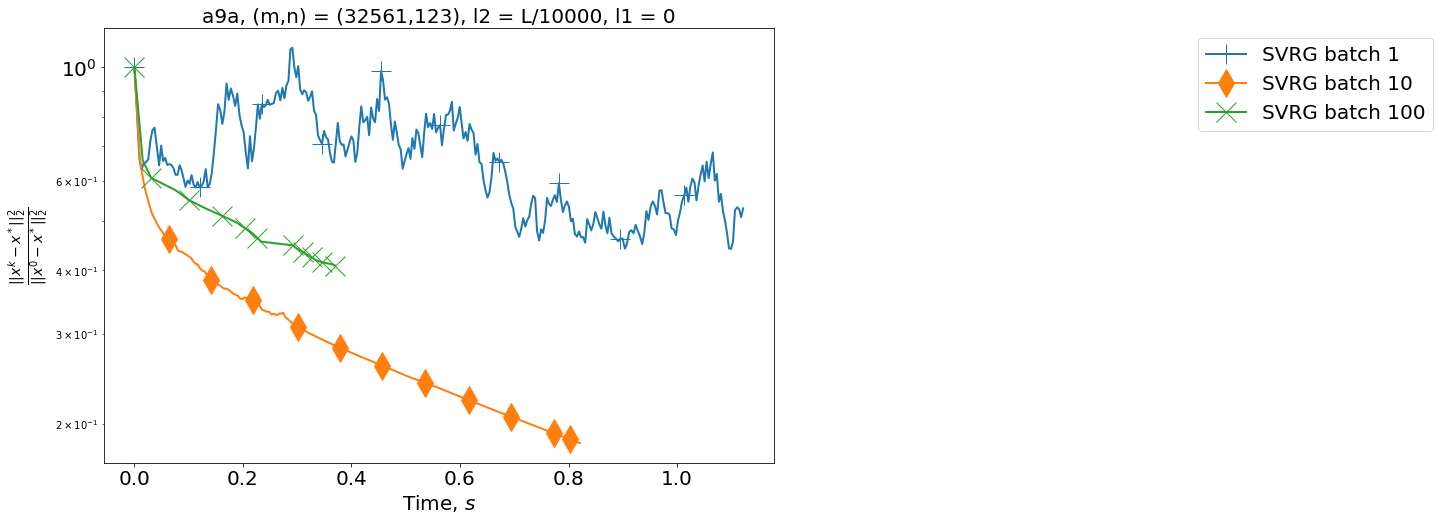

In [282]:
l1 = 0
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/1), 1], 
           ' batch 1', 300],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' batch 10', None],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/100), 100], 
           ' batch 100', None],
]
mode_x = 'time'
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

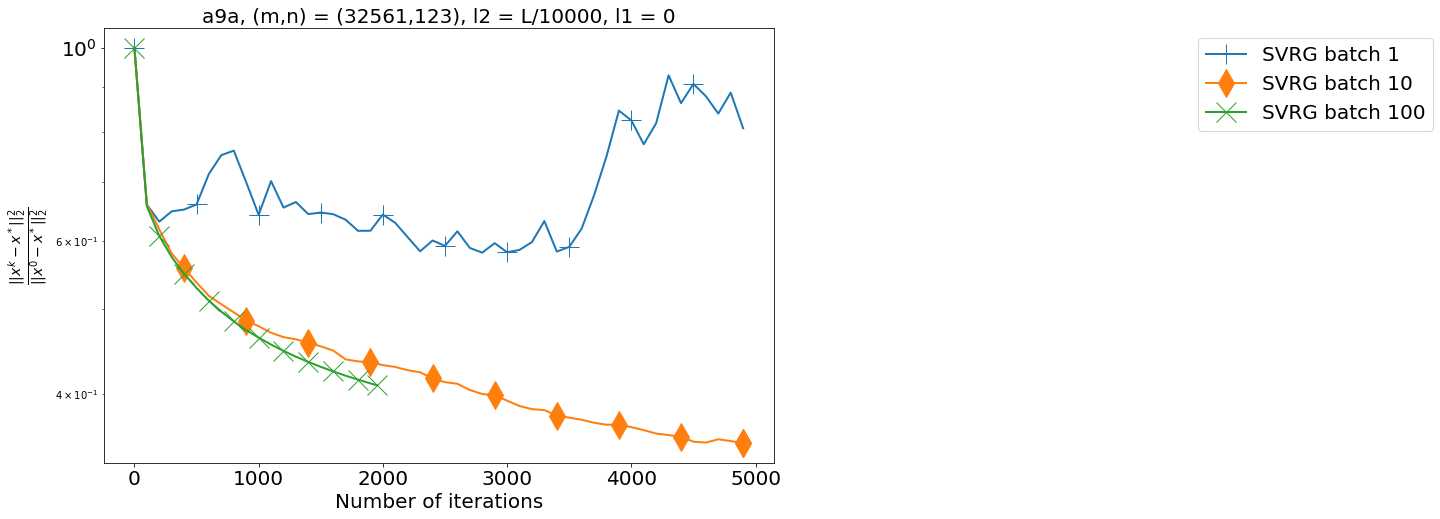

In [283]:
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/1), 1], 
           ' batch 1', 50],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' batch 10', 50],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/100), 100], 
           ' batch 100', None],
]
mode_x = 'iters'
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

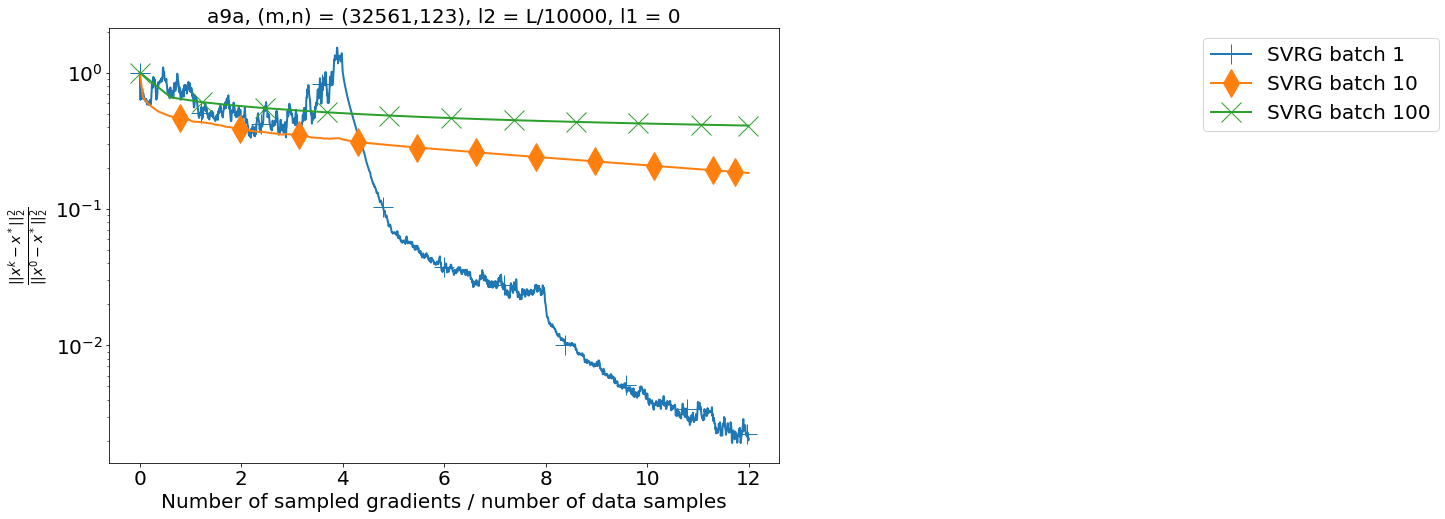

In [284]:
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/1), 1], 
           ' batch 1', None],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' batch 10', None],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/100), 100], 
           ' batch 100', None],
]
mode_x = 'data_passes'
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

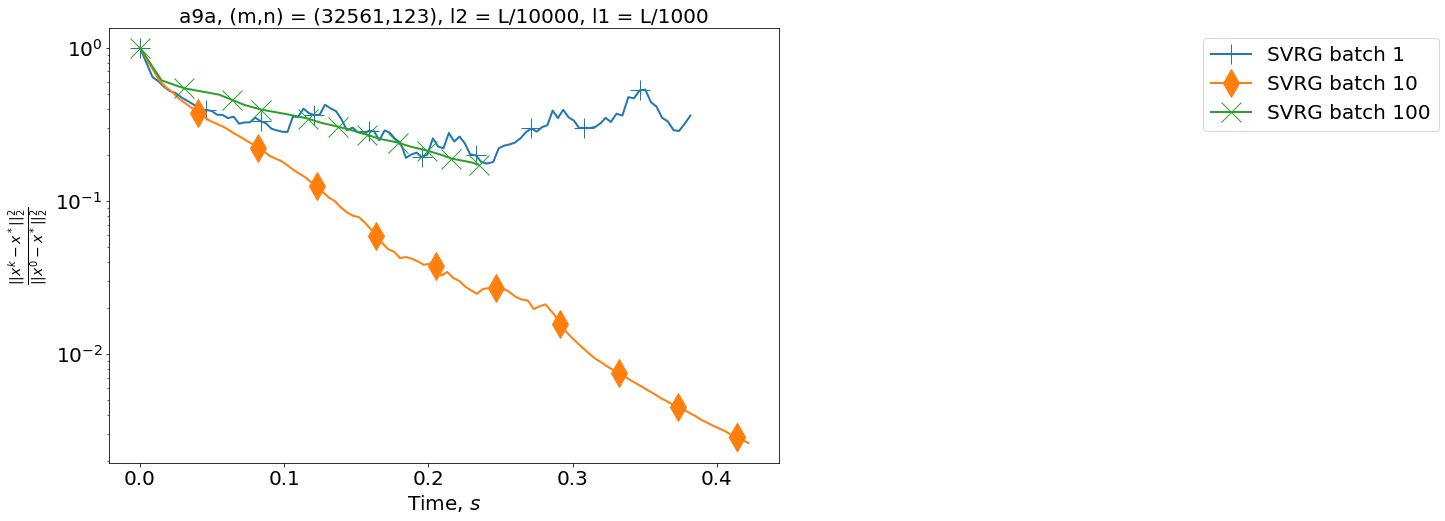

In [278]:
l1 = L / 1000
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/1), 1], 
           ' batch 1', 100],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' batch 10', 100],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/100), 100], 
           ' batch 100', None],
]
mode_x = 'time'
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

Попробуйте разные размеры батчей и разные $l_2$ и $l_1$, как это указано в задании

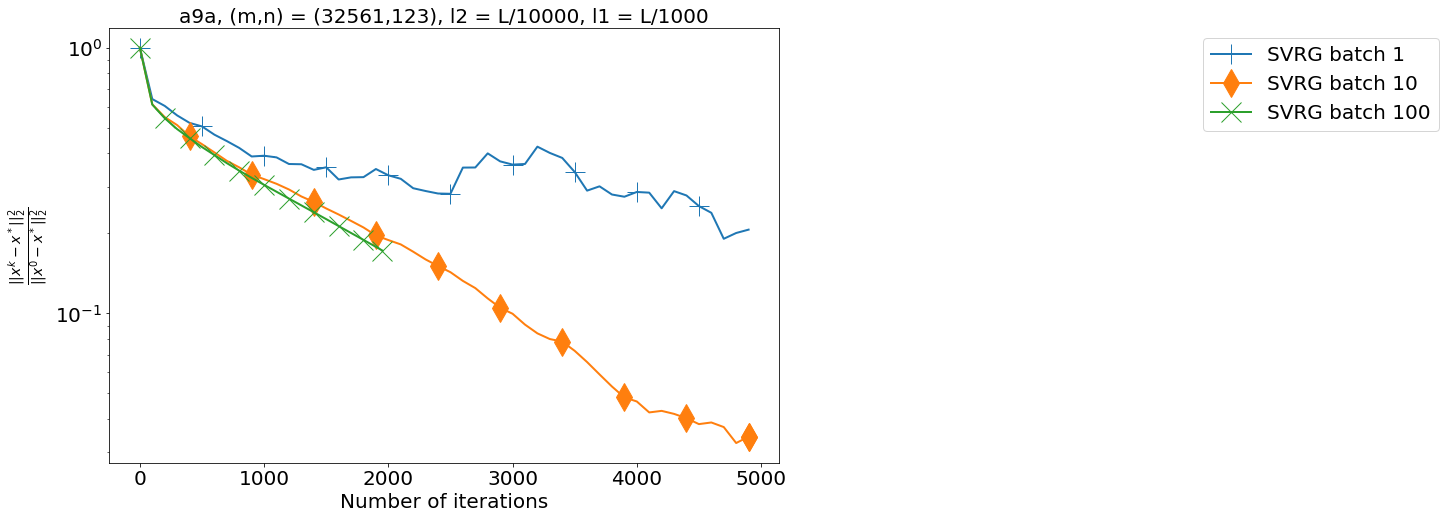

In [279]:
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/1), 1], 
           ' batch 1', 50],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' batch 10', 50],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/100), 100], 
           ' batch 100', None],
]
mode_x = 'iters'
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

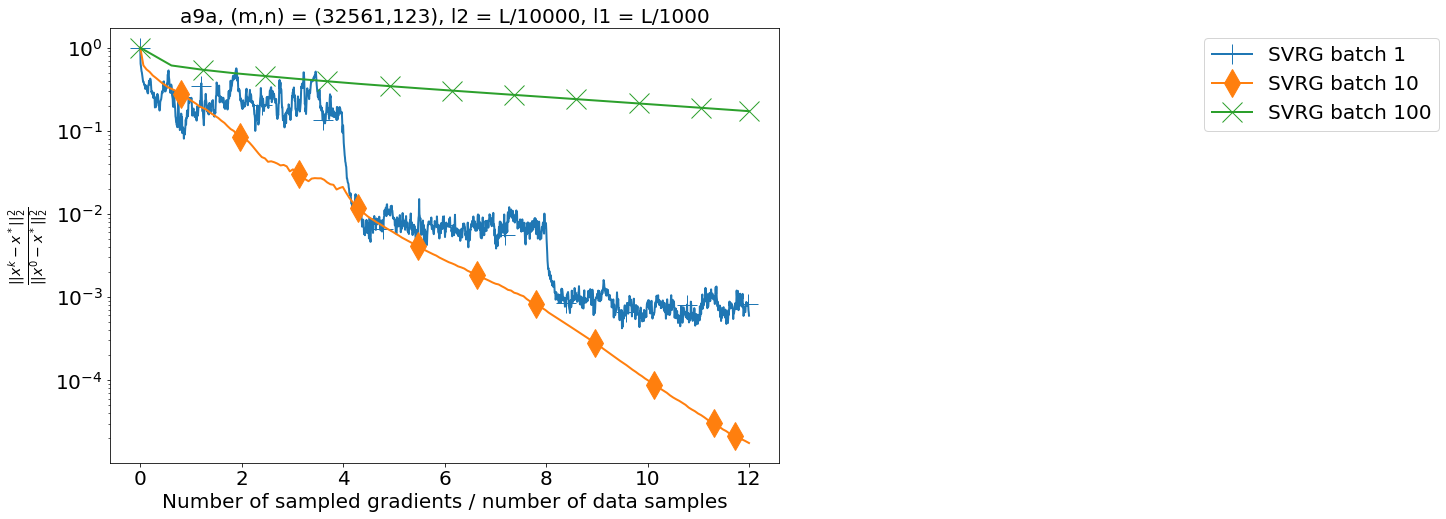

In [280]:
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/1), 1], 
           ' batch 1', None],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' batch 10', None],
         ['SVRG', [gamma, l2, l1, 3, int(2*m/100), 100], 
           ' batch 100', None],
]
mode_x = 'data_passes'
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

Выводы:
- prox-SVRG c L1 регуляризацией производит отбор признаков, в данном случае при L1 = 0.001 занулилось 28% весов. Стандартный оптимизатор с тем же коэффициентом отбор не сделал, что несколько странно, возможно на решение повлияли другие гиперпараметры, которые не оптимизировались. При L1 = 0 отбора признаков не произошло, но значение функции в точке решения стало меньше, чем с регуляризацией, что ожидаемо.
- по числу итераций метод сходится быстрее всего для батча = 100, почти с такой же скоростью сходится батч = 10, хуже всего себя показывает батч = 1. Это происходит вне зависимости от наличия L1 регуляризации
- по числу эпох батч = 100 показывает себя хуже всего в обоих случаях. Без L1 регуляризации быстрее всего сходится батч = 1, с регуляризацией - батч = 10
- по времени батч = 10 сходится быстрее всех в обоих случаях. Без регуляризации батч = 100 обгоняет батч = 1, с регуляризацией у них примерно одинаковая скорость сходимости.


## Задание 4. SGD

Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и постоянным шагом. Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и периодически уменьшающимся шагом.

In [ ]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [ ]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Запустите функцию, тестирующую корректность работы

In [ ]:
sgd_const_test(res)

In [ ]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
gamma_schedule = [gamma, 1, 0.5]
x_star = None
f_star = None
S = 10
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [ ]:
%%time
res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Запустите функцию, тестирующую корректность работы

In [ ]:
sgd_decr_test(res)

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

## Задание 5. prox-GD, FISTA и GD

Имплементируйте $\texttt{prox-GD}$, $\texttt{FISTA}$ и $\texttt{GD}$

In [ ]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [ ]:
%%time
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Запустите функцию, тестирующую корректность работы

In [ ]:
prox_gd_test(res)

In [ ]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этот параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [ ]:
%%time
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Запустите функцию, тестирующую корректность работы

In [ ]:
fista_test(res)

In [ ]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [ ]:
%%time
res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Запустите функцию, тестирующую корректность работы

In [ ]:
gd_test(res)

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

## Задание 6. Сравнение методов

## Задание 7. Эксперименты с другим датасетом